### Part 2a - Install and Configure Julia Kernel

In [4]:
using Pkg
Pkg.status()
versioninfo()

Status `~/.julia/environments/v1.10/Project.toml`
  [336ed68f] CSV v0.10.14
  [a93c6f00] DataFrames v1.6.1
  [a98d9a8b] Interpolations v0.15.1
  [b6b21f68] Ipopt v1.6.2
  [4076af6c] JuMP v1.21.1
  [2fda8390] LsqFit v0.15.0
  [91a5bcdd] Plots v1.40.4
Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, tigerlake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
  JULIA_NUM_THREADS = 


### Part 2b - Tire Force


In [5]:
using LsqFit
using CSV
using DataFrames
############## Here is a small example on how to use LsqFit ###############
# function model(input, par)
#     value = par[1] .* exp.( - input .* par[2])
#     return value
# end
# xdata = range(0, stop=10, length=20)
# ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))
# p0 = [0.5, 0.5]
# fit = curve_fit(model, xdata, ydata, p0)
# println("Your fitting value is: ", fit.param)
########## IMPORTANT COMMENT!!!: in function model(args), we add "." in front of mathematical operators to allow broadcasting (similar to Matlab) ##########


function magicFormula(input, par)
    # par = [B, C]
    # input = xdata
    #TODO Fill in the magic formula equation here
    alpha = input[:,1]
    Fz = input[:,2]
    mu = input[:,3]
    B = par[1]
    C = par[2]
    # Fy = mu .* Fz .* sin(C .* atan((B./mu).* alpha))

    Fy = mu .* Fz .* sin.(C .* atan.((B./mu) .* alpha))

    return Fy
end

TireForceDataFrame = CSV.read("TireForce.csv", DataFrame) # Load data in DataFrame mode, we recommend you to open csv to see the structure of data
TireForceMatrix = Matrix(TireForceDataFrame) # Change data format to matrix, it is formatted in the form of [alpha Fz mu Fy], each one is a N x 1 array 

# TODO prepare xdata and ydata from TireForceMatrix
xdata = TireForceMatrix[:, 1:3]
ydata = TireForceMatrix[:, end]

p0      = [1.7, 9.5]; # Initial Guess of [B, C]

#TODO Fill in function similar to the above example
fit     = curve_fit(magicFormula,xdata,ydata,p0) 

B       = round(fit.param[1]; digits = 4)
C       = round(fit.param[2]; digits = 3)
println("B coefficient is: " ,B, "  C Coefficient is: ", C)





B coefficient is: 5.68  C Coefficient is: 1.817


### Part 2c - Vehicle Bicycle Model

In [36]:
function VehicleDynamics(states, control)
    la = 1.56 
    lb = 1.64
    m = 2020
    g = 9.81
    Izz = 4095
    h = 0.6
    mu = 0.8
    x = states[1]
    y = states[2]
    v = states[3]
    r = states[4]
    ψ = states[5]
    ux = states[6]
    δf = states[7]
    ax = control[1]
    dδf = control[2]

    Fzf =  m *g * (lb/(la + lb)) - (m*h)/(la+lb) * ax #TODO Front axle load
    Fzr =  m *g * (la/(la + lb)) + (m*h)/(la+lb) * ax #TODO Rear axle load

    αf = δf - atan((v + la * r)/ux) #TODO Front slip angle
    αr = -atan((v-lb*r)/ux) #TODO Rear slip angle

    Fyf = MagicFormula(αf, Fzf, mu) #TODO Front lateral force
    Fyr = MagicFormula(αr, Fzr, mu) #TODO Rear lateral force

    dx          = ux * cos(ψ) - v * sin(ψ)#TODO 
    dy          = ux * sin(ψ) + v * cos(ψ)#TODO 
    dv          = ((Fyf + Fyr)/m) - ux * r#TODO 
    dr          = (Fyf * la - Fyr * lb)/Izz#TODO 
    dψ          =  r #TODO 
    dux         = ax #TODO 
    dδ          = dδf #TODO 
    dstates     = [dx dy dv dr dψ dux dδ]
    return dstates
end


function MagicFormula(alpha, Fz, mu)
    B =     5.68 #TODO Input Q2b value here
    C =    1.817 #TODO Input Q2b value here
    # Fy =  mu .* Fz .* sin.(C .* atan.((B./mu) .* alpha))  #TODO Lateral force calculation
    Fy =  mu * Fz * sin(C * atan((B/mu) * alpha))
    return Fy
end


x0 = [-10.0 -5.0 0.5 0.1 0.1 10.0 0.1] # This is the initial state
ctrl = [1 0.1]  # One step control action
dstates = round.(VehicleDynamics(x0, ctrl); digits = 3) # Calculate states derivative
println("The states derivative is: ", dstates)

The states derivative is: [9.9 1.496 -1.004 2.587 0.1 1.0 0.1]


In [11]:
transpose(dstates)
# dstates'

7×1 transpose(::Matrix{Float64}) with eltype Float64:
  9.9
  1.496
 -1.004
  2.587
  0.1
  1.0
  0.1

### Part 2d - Vehicle Dynamics Propagation

In [37]:
# include("Q2c_VehicleDynamics.jl")

function Propagation(states, control, δT)
    #TODO Calculate states derivative using function
    #  VehicleDynamics(args).
    dstates =  VehicleDynamics(states, control)

    #TODO Calculate next Step
    # This is Explicit ForwardEuler
    statesNext = states + dstates .* δT
    return statesNext
end

#Testing purposes
x0 = [-10.0 -5.0 0.5 0.1 0.1 10.0 0.1] # This is the initial state
ctrl = [1 0.1]  # One step control action
δT = 0.01
# statesNextTemp = Propagation(x0,ctrl,δT)
statesNextTemp = round.(Propagation(x0,ctrl,δT); digits = 3) 
println("The statesNextTemp  is: ", statesNextTemp)

The statesNextTemp  is: [-9.901 -4.985 0.49 0.126 0.101 10.01 0.101]


In [16]:
statesNext = StatesListFE02[1, :] .+ dstates .* dt1 #broadcast huh

7×7 Matrix{Float64}:
 -8.0  -10.0  -10.0  -10.0  -10.0  -9.8  -9.98
 -3.0   -5.0   -5.0   -5.0   -5.0  -4.8  -4.98
  2.0    0.0    0.0    0.0    0.0   0.2   0.02
  2.0    0.0    0.0    0.0    0.0   0.2   0.02
  2.0    0.0    0.0    0.0    0.0   0.2   0.02
 12.0   10.0   10.0   10.0   10.0  10.2  10.02
  2.0    0.0    0.0    0.0    0.0   0.2   0.02

In [15]:
print(size(Propagation(reshape(StatesListFE02[1, :],(1,7)), control, dt1)))

(1, 7)

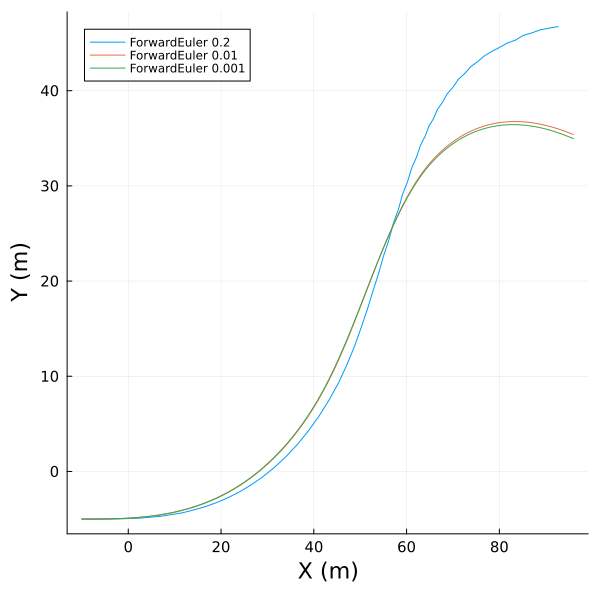

In [38]:
using Interpolations
using Plots
# include("Q2c_VehicleDynamics.jl")
# include("Q2d_StatesPropagator.jl")
x0 = [-10.0 -5.0 0.0 0.0 0.0 10.0 0.0]
ctrl = [1 0.1]
dstates = VehicleDynamics(x0, ctrl)


tc      = [0, 4, 8, 12]  # Key time step for control input
dδfc    = [0, 0.02, -0.05, 0.02] # Key value for steering rate
axc     = [0, 1.0, -2.0, 1.0] # Key value for acceleration
dt1      = 0.2  # Simulation dt
t1       = 0:dt1:tc[end]
Interpolatedδf = interpolate((tc ,), dδfc, Gridded(Constant{Next}())) # Interpolations
Interpolateax = interpolate((tc ,), axc, Gridded(Constant{Next}()))
dδf1    = Interpolatedδf.(t1) # Get interpolated steering rate signal
ax1     = Interpolateax.(t1) # Get interpolated acceleration signal

StatesListFE02 = zeros(size(t1, 1), size(x0, 2)) # Initialize states list for 0.2 update time
StatesListFE02[1, :] = x0 # Initial point

control = zeros(2,1) # Init control input

for i = 1:size(StatesListFE02, 1) - 1

    # TODO calculate the next states
    control[1] = ax1[i]
    control[2] = dδf1[i]
    StatesListFE02[i + 1, :] = Propagation(reshape(StatesListFE02[i, :],(1,7)), control, dt1)
end

dt2     = 0.01 # Smaller time step
t2      = 0:dt2:tc[end]
dδf2     = Interpolatedδf.(t2)
ax2      = Interpolateax.(t2)

StatesListFE001 = zeros(size(t2, 1), size(x0, 2)) # Initialize states list for 0.01 update time
StatesListFE001[1, :] = x0 # Initial point

for i = 1:size(StatesListFE001, 1) - 1

    # TODO calculate the next states
    control[1] = ax2[i]
    control[2] = dδf2[i]
    StatesListFE001[i + 1, :] = Propagation(reshape(StatesListFE001[i, :],(1,7)), control, dt2)
end


dt3     = 0.001 # Smaller time step
t3      = 0:dt3:tc[end]
dδf3     = Interpolatedδf.(t3)
ax3      = Interpolateax.(t3)

StatesListFE0001 = zeros(size(t3, 1), size(x0, 2)) # Initialize states list for 0.001 update time
StatesListFE0001[1, :] = x0 # Initial point

for i = 1:size(StatesListFE0001, 1) - 1

    # TODO calculate the next states
    control[1] = ax3[i]
    control[2] = dδf3[i]
    StatesListFE0001[i + 1, :] = Propagation(reshape(StatesListFE0001[i, :],(1,7)), control, dt3)
end

p = plot(size = [600, 600])
plot!(p, StatesListFE02[:, 1], StatesListFE02[:, 2], label = "ForwardEuler " * string(dt1), tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15)
plot!(p, StatesListFE001[:, 1], StatesListFE001[:, 2], label = "ForwardEuler " * string(dt2))
plot!(p, StatesListFE0001[:, 1], StatesListFE0001[:, 2], label = "ForwardEuler " * string(dt3))


### Part 2e - Optimal Control

Refer to : https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/space_shuttle_reentry_trajectory/

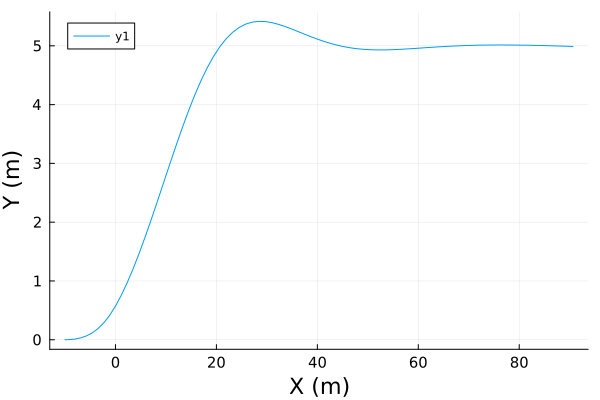

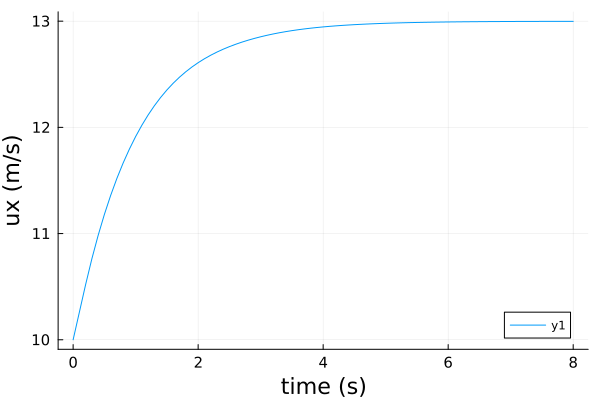

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2473
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3602

Total number of variables............................:      722
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      722
                     variables with only upper bounds:        0
Total number of equality constraints.................:      560
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1142900e+02 9.50e+00 2.64e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [39]:
using JuMP
using Ipopt
using Plots
# include("Q2c_VehicleDynamics.jl")

x0 = [-10.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0] #TODO Initial Condition
XL = [-40, -20, -3, -pi/5,  -pi/2, 5.0, -pi/12] # States Lower Bound
XU = [300, 20, 3, pi/5, pi/2, 15.0, pi/12] #TODO States Upper Bound
CL = [-2.6, -0.1] #TODO Control Lower Bound
CU = [2.6, 0.1] #TODO Control Upper Bound

model = Model(optimizer_with_attributes(Ipopt.Optimizer)) # Initialize JuMP model

numStates = 7 #TODO number of states
numControls = 2 #TODO number of control
PredictionHorizon = 8 #TODO Prediction Time
numColPoints = 81 #TODO 
Δt = PredictionHorizon/(numColPoints - 1)# Time interval

@variables(model, begin
    # Set xst as a numColPoints x numStates matrix that is between the upper and lower states bounds
    XL[i] ≤ xst[j in 1:numColPoints, i in 1:numStates]  ≤ XU[i]
    #TODO Similarly, set u as a numColPoints x numControls matrix that is 
    # between the upper and lower control bounds
    CL[i] ≤ u[j in 1:numColPoints, i in 1:numControls] ≤ CU[i]
end)

# Fix initial conditions
fix(xst[1, 1], x0[1]; force = true) # set the initial condition for x-position value
#TODO Follow the same way, set the remaining initial conditions, 
# set x0[2] to xst[1,2],... and so on.
fix(xst[1,2],x0[2];force = true)
fix(xst[1,3],x0[3];force = true)
fix(xst[1,4],x0[4];force= true)
fix(xst[1,5],x0[5];force= true)
fix(xst[1,6],x0[6];force= true)
fix(xst[1,7],x0[7];force= true)


# sa means steering angle, sr means steering rate
x = xst[:, 1]; y = xst[:, 2]; v = xst[:, 3]; r = xst[:, 4]; ψ = xst[:, 5]; 
ux = xst[:, 6]; sa = xst[:, 7]; 
ax = u[:, 1]; # retract variable 
sr = u[:, 2]; 

# δxst = Matrix{Any}(undef, numColPoints, numStates)
# write the states derivative for all states & controls
δxst = Matrix{Any}(undef, numColPoints, numStates)
for i = 1:1:numColPoints
    δxst[i, :] = @expression(model, VehicleDynamics(xst[i, :], u[i, :]))
    # δxst[i, :] = @expression(model, VehicleDynamics(reshape(xst[i, :],(1,7)),
    #  reshape(u[i, :],(1,2))))
end

# add constraint to each state using backward Euler method
for j = 2:numColPoints
    for i = 1:numStates
        @constraint(model, xst[j, i] == xst[j - 1, i] +Δt * δxst[j, i])
    end
end


# TODO write the cost function for each term - Lane change
y_cost = @expression(model, sum((y[j] - 5)^2 * Δt for j= 1:1:numColPoints)) #global y position of C.G Cost
sr_cost = @expression(model, sum((sr[j])^2 * Δt for j= 1:1:numColPoints))
sa_cost = @expression(model, sum((sa[j])^2 * Δt for j= 1:1:numColPoints))
ux_cost = @expression(model, sum((ux[j] - 13)^2 * Δt for j= 1:1:numColPoints))
ax_cost = @expression( model, sum((ax[j])^2 * Δt for j=1:1:numColPoints)) # ax cost


#TODO define cost weight
w_y  = 0.05 # change later for 2f
w_sr = 2.0
w_ax = 0.2
w_ux = 0.2
w_sa = 1.0

# Objective: Minimize cost function
@objective(model, Min, w_y * y_cost + w_sr * sr_cost + w_ax * ax_cost + w_ux * ux_cost + w_sa * sa_cost) # objective value
optimize!(model) # optimize model
StatesHis = value.(model[:xst]) # retrieve data
if abs(objective_value(model) - 3.65) < 0.1 # check answer
    println("Congrats, your answer is correct")
else
    println("Something went wrong, please try again!")
end

println("Objective value model = ",objective_value(model))
println("Your y cost is:  ", round(value(y_cost); digits = 3))

#Plot
# plot(StatesHis[:, 1], StatesHis[:, 2], tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15) # path plot
# plot(0:Δt:PredictionHorizon, StatesHis[:, 6], tickfontsize = 10, xlabel = "time (s)", ylabel = "ux (m/s)",guidefont=15) # Speed plot

display(plot(StatesHis[:, 1], StatesHis[:, 2], tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15)) # path plot
display(plot(0:Δt:PredictionHorizon, StatesHis[:, 6], tickfontsize = 10, xlabel = "time (s)", ylabel = "ux (m/s)",guidefont=15)) # Speed plot)


### Part 2f - Cost Weights

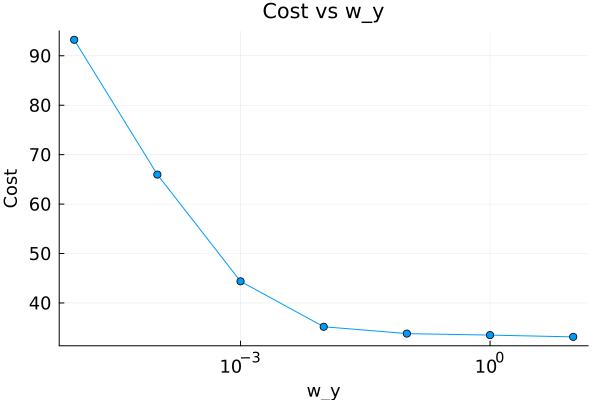

In [43]:
# using Pkg
# Pkg.add("Plots")
using Plots

w_y = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

# TODO value of cost function
cost = [93.24, 65.966, 44.373, 35.183, 33.798, 33.495, 33.135]

# Using the `semilogx` function from Plots.jl to create a semilogarithmic plot
# You can customize the plot using the `xlabel!`, `ylabel!`, and `title!` functions
# or by passing attributes directly within the `plot` function.
plot(w_y, cost, xscale=:log10, markershape = :circle,
    xlabel="w_y", ylabel="Cost", title="Cost vs w_y", legend=false)

# to customize the fontsize, you can use `fontsize()` function of the underlying backend
# For example, default GR backend:
plot!(tickfontsize=12, labelfontsize=12, guidefontsize=12)
# If the Plots backend you are using supports it, you can customize fonts further.

### Part 2g - Obstacle Avoidance

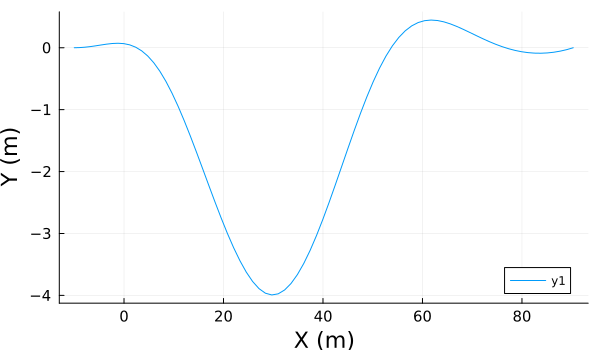

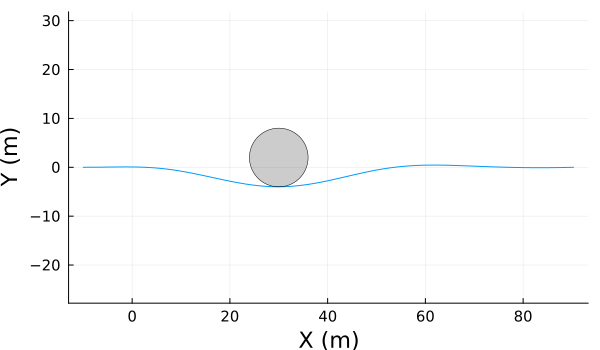

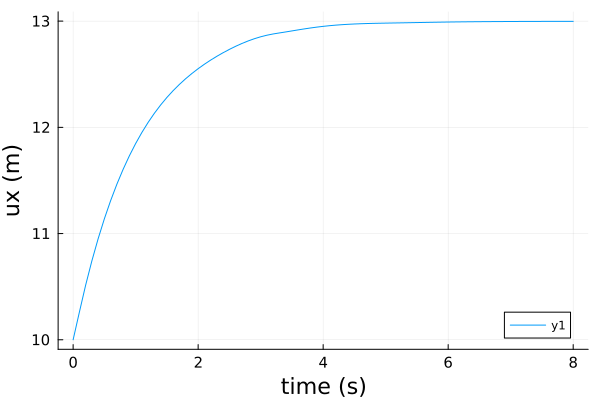

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2473
Number of nonzeros in inequality constraint Jacobian.:      320
Number of nonzeros in Lagrangian Hessian.............:     3762

Total number of variables............................:      722
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      722
                     variables with only upper bounds:        0
Total number of equality constraints.................:      560
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       81

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0130400e+02 9.50e+00 7.65e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [40]:
using JuMP
using Ipopt
using Plots
# include("Q2c_VehicleDynamics.jl")

function circleShape(h,k,r)
    θ = LinRange(0, 2*π, 500)
    h.+r*sin.(θ), k.+r*cos.(θ)
end

x0 = [-10.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0] #TODO Initial Condition
XL = [-40, -20, -3, -pi/5,  -pi/2, 5.0, -pi/12] # States Lower Bound
XU = [300, 20, 3, pi/5, pi/2, 15.0, pi/12] #TODO States Upper Bound
CL = [-2.6, -0.1] #TODO Control Lower Bound
CU = [2.6, 0.1] #TODO Control Upper Bound

model = Model(optimizer_with_attributes(Ipopt.Optimizer)) # Initialize JuMP model

numStates = 7 #TODO number of states
numControls = 2 #TODO number of control
PredictionHorizon = 8 #TODO Prediction Time
numColPoints = 81 #TODO 
Δt = PredictionHorizon/(numColPoints - 1)# Time interval

@variables(model, begin
    # Set xst as a numColPoints x numStates matrix that is 
    # between the upper and lower states bounds
    XL[i] ≤ xst[j in 1:numColPoints, i in 1:numStates]  ≤ XU[i]
    #TODO Set u as a numColPoints x numControls matrix that is between the
    #  upper and lower control bounds
    CL[i] ≤ u[j in 1:numColPoints, i in 1:numControls] ≤ CU[i]
end)


fix(xst[1, 1], x0[1]; force = true) # set the initial condition for x-position value
#TODO Follow the same way, set the remaining initial conditions, set x0[2] to xst[1,2],... and so on.
fix(xst[1,2],x0[2];force = true)
fix(xst[1,3],x0[3];force = true)
fix(xst[1,4],x0[4];force= true)
fix(xst[1,5],x0[5];force= true)
fix(xst[1,6],x0[6];force= true)
fix(xst[1,7],x0[7];force= true)


x = xst[:, 1]; y = xst[:, 2]; v = xst[:, 3]; r = xst[:, 4]; ψ = xst[:, 5]; 
ux = xst[:, 6]; sa = xst[:, 7]; 
ax = u[:, 1]; # retract variable 
sr = u[:, 2]; 

# δxst = Matrix{Any}(undef, numColPoints, numStates)
# write the states derivative for all states & controls
δxst = Matrix{Any}(undef, numColPoints, numStates)
for i = 1:1:numColPoints
    δxst[i, :] = @expression(model, VehicleDynamics(xst[i, :], u[i, :]))
end

# add constraint to each state using backward Euler method
for j = 2:numColPoints
    for i = 1:numStates
        @constraint(model, xst[j, i] == xst[j - 1, i] +Δt * δxst[j, i])
    end
end


# TODO write the cost function for each term
y_cost = @expression(model, sum((y[j])^2 * Δt for j= 1:1:numColPoints)) #global y position of C.G Cost
sr_cost = @expression(model, sum((sr[j])^2 * Δt for j= 1:1:numColPoints))
sa_cost = @expression(model, sum((sa[j])^2 * Δt for j= 1:1:numColPoints))
ux_cost = @expression(model, sum((ux[j] - 13)^2 * Δt for j= 1:1:numColPoints))
ax_cost = @expression( model, sum((ax[j])^2 * Δt for j=1:1:numColPoints)) # ax cost



#TODO define cost weight
w_y  = 0.05 # change later for 2f
w_sr = 2.0
w_ax = 0.2
w_ux = 0.2
w_sa = 1.0


block_list = [30.0 2 6] # block_list = [obstacle_x_center, obstacle_y_center, radius]

# TODO add obstacle avoidance constraint
obs_constraint = @constraint(model, [i = 1:numColPoints], 
1 <=  ((x[i]-block_list[1])^2+(y[i]-block_list[2])^2)/(block_list[3])^2
)



@objective(model, Min, w_y * y_cost + w_sr * sr_cost + w_ax * ax_cost + w_ux * ux_cost + w_sa * sa_cost) # objective value
optimize!(model) # optimize model
StatesHis = value.(model[:xst]) # retrieve data


println("Your y cost is:  ", round(value(y_cost); digits = 3))

p = plot(size=(600, 350))
display(plot!(p, StatesHis[:, 1], StatesHis[:, 2], tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15))# path plot
display(plot!(p, circleShape(block_list[1], block_list[2], block_list[3]), seriestype = [:shape,], ;w = 0.5, c=:black, linecolor = :black, legend = false, fillalpha = 0.2, aspect_ratio=:equal))
display(plot(0:Δt:PredictionHorizon, StatesHis[:, 6], tickfontsize = 10, xlabel = "time (s)", ylabel = "ux (m)",guidefont=15)) # Speed plot

